In [1]:
pwd

'/media/kexin/SSD/git_repos/robust-physical-attack'

In [1]:
import os
import sys
import time
import math
import tarfile
import zipfile
import PIL.Image
import numpy as np
import tensorflow as tf
import six.moves.urllib as urllib

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
# from cStringIO import StringIO
from io import BytesIO
from IPython.display import clear_output, Image, display, HTML
from object_detection.utils import label_map_util
from object_detection.utils.visualization_utils import visualize_boxes_and_labels_on_image_array
from object_detection.core import target_assigner

#Model preparation

In [2]:
OBJ_DETECT_API='~/data/'

MODEL_NAME = 'faster_rcnn_inception_v2_coco_2017_11_08'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'data/mscoco_label_map.pbtxt'

NUM_CLASSES = 90

# Download Model

In [3]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

# Loading label map

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Utility functions for loading and displaying images

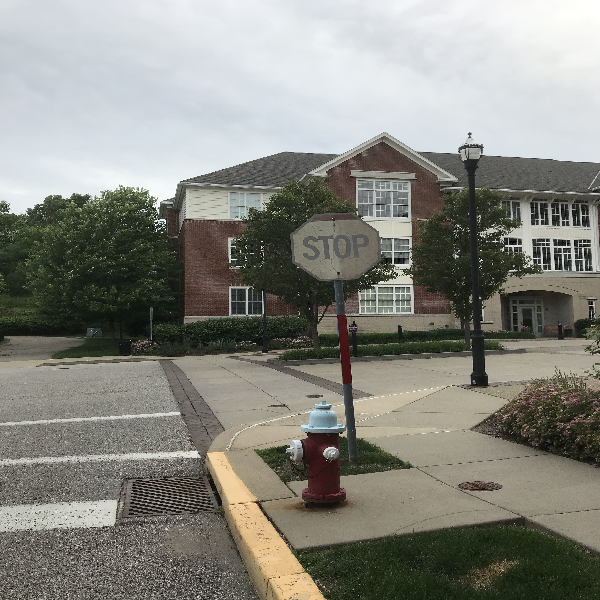

In [35]:
def read_image(path):
    img = PIL.Image.open(path).resize((psize, psize))
    img = np.array(img, dtype=np.uint8)
    return img

def showarray(a, fmt='png'):
    a = np.uint8(a)
#     f = StringIO()
    f=BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


img = read_image('data/stop-sign-photo-900x817.jpg')
# img = np.rot90(read_image('faded.jpg'),3)
showarray(img)

# Loading the mask
There are 2 masks, one for the red part of stop sign and one for the white part.

In [7]:
# size of the perturbation we want to generate
psize = 600

# Loading the model for inference

In [19]:
inference_graph = tf.Graph()
with inference_graph.as_default():
    image_tensor = tf.placeholder(tf.float32, shape=(None, psize, psize, 3), name='image_tensor')
    inference_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        inference_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(inference_graph_def, name='',
                            input_map={'Preprocessor/map/TensorArrayStack/TensorArrayGatherV3:0':image_tensor})

# Defining some plotting utility functions

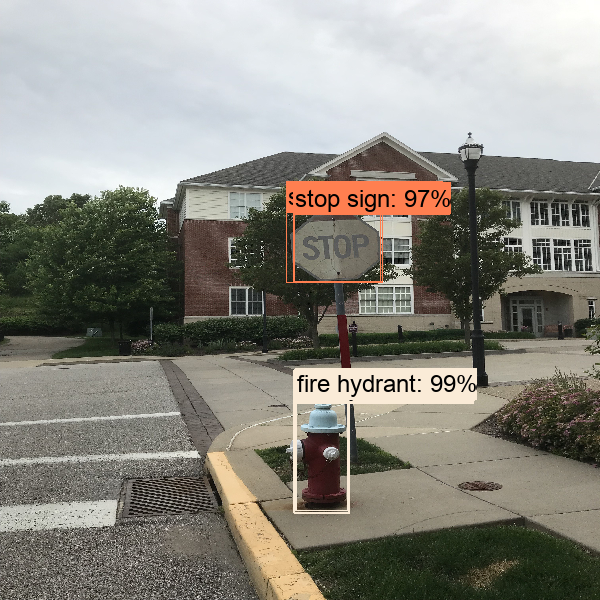

In [37]:
def preprocess(img):
    return img / 255 * 2 - 1

def deprocess(img):
    return (img + 1) / 2 * 255

def plot_detections(img, scores=None, bboxes=None, min_threshold=0):
    if scores is None or bboxes is None:
        inference_sess = tf.Session(graph=inference_graph)

        tensors = [ inference_graph.get_tensor_by_name('detection_boxes:0'),
                    inference_graph.get_tensor_by_name('detection_scores:0'),
                    inference_graph.get_tensor_by_name('detection_classes:0'),
                    inference_graph.get_tensor_by_name('num_detections:0'),
                    inference_graph.get_tensor_by_name('SecondStagePostprocessor/Reshape_4:0'),
                    inference_graph.get_tensor_by_name('SecondStagePostprocessor/convert_scores:0') ]

        feed_dict = { inference_graph.get_tensor_by_name('image_tensor:0'): np.expand_dims(img, axis=0) }

        nms_bboxes, nms_scores, nms_classes, num_detections, bboxes, scores = inference_sess.run(tensors,
                                                                                                 feed_dict)
        
        bboxes = bboxes[0]
        scores = scores[0]
    
    sorted_classes = np.argsort(scores[:, 1:], axis=1)
    sorted_scores = scores[:, 1:].copy()
    sorted_bboxes = bboxes.copy()

    for i, ordering in enumerate(sorted_classes):
        sorted_scores[i, :] = scores[i, ordering+1]
        sorted_bboxes[i, :] = bboxes[i, ordering, :]

    sorted_classes += 1

    img_viz = visualize_boxes_and_labels_on_image_array(img.copy(), 
                                                        sorted_bboxes[:, -1, :],
                                                        sorted_classes[:, -1].astype(np.int32),
                                                        sorted_scores[:, -1],
                                                        category_index,
                                                        use_normalized_coordinates=False,
                                                        max_boxes_to_draw=sorted_scores.shape[1],
                                                        min_score_thresh=min_threshold,
                                                        line_thickness=1)
    showarray(img_viz)

img = preprocess(img) 
plot_detections(deprocess(img), min_threshold=0.5)

# Define the optimization model

In [21]:
class ModelContainer():
    def __init__(self):
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph)
        self._make_model_and_ops()

    def train_step(self, images, second_stage_cls_labels, learning_rate=1.0, rpn_nms_bboxes=None, rpn_nms_indices=None):
        self.assign_img(images)
        if (rpn_nms_bboxes is None) or \
                (rpn_nms_indices is None):
            rpn_nms_bboxes, rpn_nms_indices = self.inference_rpn()

        # feed_dict = {self.image_input_: images,
        #              self.second_stage_cls_labels_: second_stage_cls_labels,
        #              self.rpn_nms_bboxes_placeholder_: rpn_nms_bboxes,
        #              self.rpn_nms_indices_placeholder_: rpn_nms_indices,
        #              self.learning_rate_: learning_rate}

        feed_dict = {self.second_stage_cls_labels_: second_stage_cls_labels,
                     self.rpn_nms_bboxes_placeholder_: rpn_nms_bboxes,
                     self.rpn_nms_indices_placeholder_: rpn_nms_indices,
                     self.learning_rate_: learning_rate}

        tensors = [self.train_op_,
                   self.loss_,
                   self.gradients]

        _, loss, grads = self._run(tensors, feed_dict)

        tensors = self.img
        ret_img = self._run(tensors, feed_dict)

        return loss, ret_img, grads

    def assign_img(self, new_img):
        self._run(self.assign_img_, {self.image_input_: new_img})

    def inference_rpn(self):
        # feed_dict = {self.image_input_: images}
        feed_dict = {}

        tensors = [self.rpn_nms_bboxes_,
                   self.rpn_nms_indices_]

        rpn_nms_bboxes, rpn_nms_indices = self._run(tensors, feed_dict)

        return rpn_nms_bboxes, rpn_nms_indices

    def inference(self, images, rpn_nms_bboxes=None, rpn_nms_indices=None):
        self.assign_img(images)
        if (rpn_nms_bboxes is None) or \
                (rpn_nms_indices is None):
            rpn_nms_bboxes, rpn_nms_indices = self.inference_rpn()

        # feed_dict = {self.image_input_: images,
        #              self.rpn_nms_bboxes_placeholder_: rpn_nms_bboxes,
        #              self.rpn_nms_indices_placeholder_: rpn_nms_indices}

        feed_dict = {self.rpn_nms_bboxes_placeholder_: rpn_nms_bboxes,
                     self.rpn_nms_indices_placeholder_: rpn_nms_indices}

        tensors = [self.clipped_img_,
                   self.second_stage_cls_scores_,
                   self.second_stage_loc_bboxes_]

        clipped_img_, second_stage_cls_scores, second_stage_loc_bboxes = self._run(tensors, feed_dict)
        clipped_img_ = clipped_img_.astype(np.uint8)
        plot_detections(clipped_img_[0], scores=second_stage_cls_scores[0], bboxes=second_stage_loc_bboxes[0],
                        min_threshold=0.2)

        return second_stage_cls_scores, second_stage_loc_bboxes

    def _run(self, target, feed_dict=None):
        if feed_dict is None:
            feed_dict = {}

        return self.sess.run(target, feed_dict=feed_dict)

    def _brighten(self, gvs):
        assert len(gvs) == 1  # only 1 image
        gv = gvs[0]
        brighten_gv = tf.ones_like(gv)
        return [tf.reduce_mean(gv) * brighten_gv]

    def _make_model_and_ops(self):
        start = time.time()
        with self.sess.graph.as_default():
            tf.set_random_seed(1234)

            # Tensors are post-fixed with an underscore
            self.image_input_ = tf.placeholder(tf.float32, shape=(None, psize, psize, 3), name='image_input')
            self.img = tf.get_variable('img', (1, psize, psize, 3), dtype=tf.float32,
                                       initializer=tf.zeros_initializer)
            self.assign_img_ = tf.assign(self.img, self.image_input_)

            self.clipped_img_ = tf.fake_quant_with_min_max_vars((self.img + 1) * 127.5, min=0, max=255)

            # Create placeholders for NMS RPN inputs
            self.rpn_nms_bboxes_placeholder_ = tf.placeholder(tf.float32, shape=(None, 4), name='rpn_nms_bboxes')
            self.rpn_nms_indices_placeholder_ = tf.placeholder(tf.int32, shape=(None), name='rpn_nms_indices')

            detection_graph_def = tf.GraphDef()
            with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
                serialized_graph = fid.read()
                detection_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(detection_graph_def, name='detection',
                                    input_map={
                                        'Preprocessor/map/TensorArrayStack/TensorArrayGatherV3:0': self.clipped_img_,
                                        'Reshape_7:0': self.rpn_nms_bboxes_placeholder_,
                                        'Reshape_8:0': self.rpn_nms_indices_placeholder_,
                                    })

            # Recreate tensors we just replaced in the input_map
            self.rpn_nms_bboxes_ = tf.reshape(self.graph.get_tensor_by_name('detection/Reshape_6:0'),
                                              self.graph.get_tensor_by_name('detection/stack_3:0'),
                                              name='detection/Reshape_7')
            self.rpn_nms_indices_ = tf.reshape(self.graph.get_tensor_by_name('detection/mul_1:0'),
                                               self.graph.get_tensor_by_name('detection/Reshape_8/shape:0'),
                                               name='detection/Reshape_8')

            # Second-stage Class Loss
            self.second_stage_cls_scores_ = self.graph.get_tensor_by_name(
                'detection/SecondStagePostprocessor/convert_scores:0')
            second_stage_cls_logits_ = self.graph.get_tensor_by_name(
                'detection/SecondStagePostprocessor/scale_logits:0')
            self.second_stage_cls_labels_ = tf.placeholder(tf.float32, shape=second_stage_cls_logits_.shape,
                                                           name='second_stage_cls_labels')
            second_stage_cls_losses_ = tf.nn.softmax_cross_entropy_with_logits_v2(
                labels=tf.reshape(self.second_stage_cls_labels_, (-1, self.second_stage_cls_labels_.shape[2])),
                logits=tf.reshape(second_stage_cls_logits_, (-1, second_stage_cls_logits_.shape[2])))
            second_stage_cls_losses_ = tf.reshape(second_stage_cls_losses_,
                                                  (-1, self.second_stage_cls_labels_.shape[1]))
            second_stage_cls_losses_ = tf.divide(second_stage_cls_losses_,
                                                 tf.cast(self.second_stage_cls_labels_.shape[1], tf.float32))
            self.second_stage_cls_loss_ = tf.reduce_sum(second_stage_cls_losses_)
            #             self.second_stage_cls_loss_ = tf.reduce_mean(second_stage_cls_losses_)

            # Second-stage bounding boxes
            self.second_stage_loc_bboxes_ = self.graph.get_tensor_by_name(
                'detection/SecondStagePostprocessor/Reshape_4:0')

            # Sum of weighted losses
            self.loss_ = self.second_stage_cls_loss_

            # Train attack by only training on the input image
            self.learning_rate_ = tf.placeholder(tf.float32)
            optimizer = tf.train.GradientDescentOptimizer(self.learning_rate_)
            self.gradients, variables = zip(*optimizer.compute_gradients(self.loss_, var_list=[self.img]))
            self.gradients = self._brighten(self.gradients)
            self.train_op_ = optimizer.apply_gradients(zip(self.gradients, variables))

            elapsed = time.time() - start
            print("Finished loading the model, took {:.0f}s".format(elapsed))


model = ModelContainer()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Finished loading the model, took 2s


# Create target labels

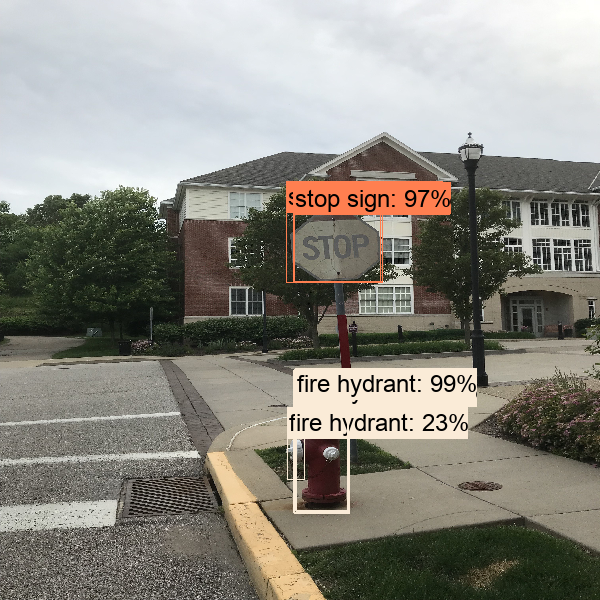

In [22]:
# TARGET_CLASS = 13 # untargeted attack: maximize distance to class: 13 - stop sign
TARGET_CLASS = 1 # targeted attack: minimize distance to class: 1 - person

def create_target_labels(scores, from_class, to_class):
    target_labels = np.zeros_like(scores)
    classes = np.argmax(scores[:, :, 1:], axis=2)+1

    for i, _ in enumerate(classes):
        for j, cls in enumerate(classes[i]):
            cls = to_class # Just perturb all of them!
            target_labels[i, j, cls] = 1

    return target_labels

test_img = np.expand_dims(img, axis=0)

scores, _ = model.inference(test_img)
target_labels = create_target_labels(scores, 13, TARGET_CLASS)

# Run the optimization

iter 0 total loss: 9.665464401245117


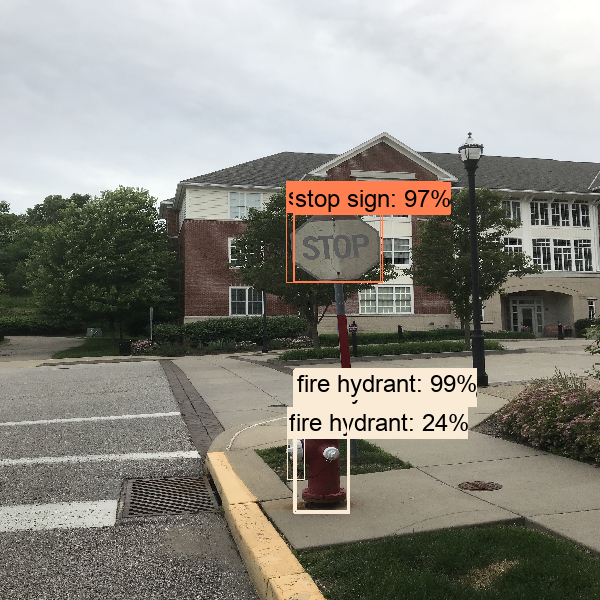

iter 20 total loss: 9.665464401245117


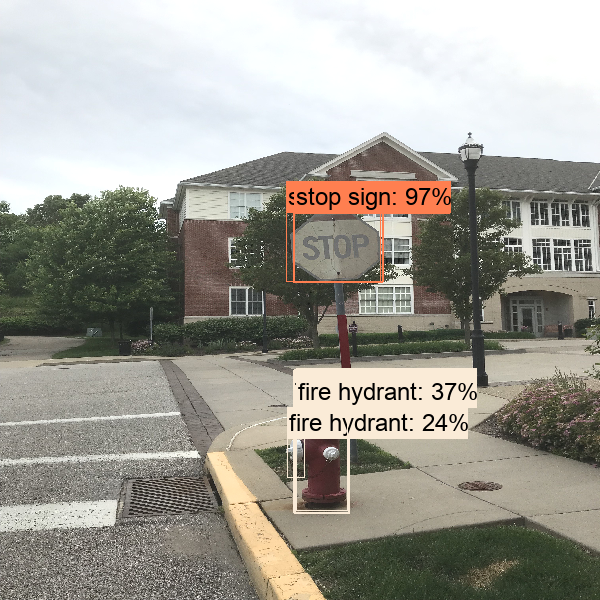

iter 40 total loss: 9.665464401245117


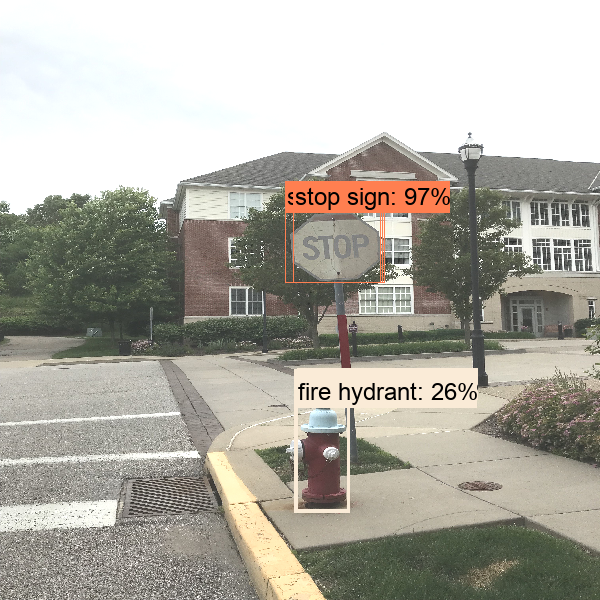

iter 60 total loss: 9.665464401245117


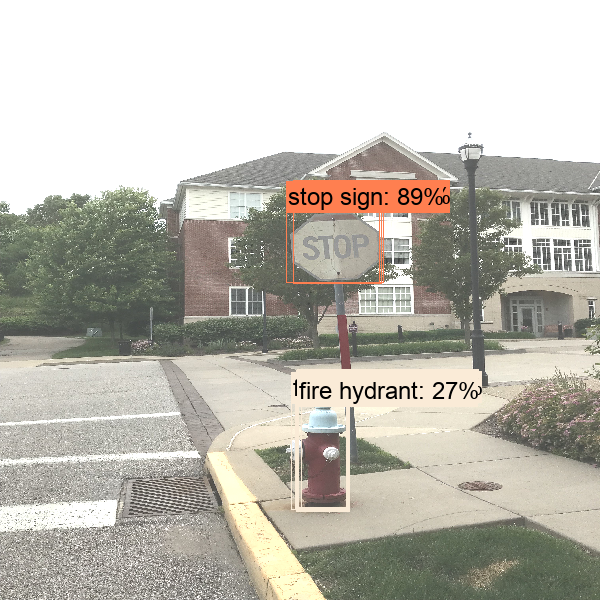

iter 80 total loss: 9.665464401245117


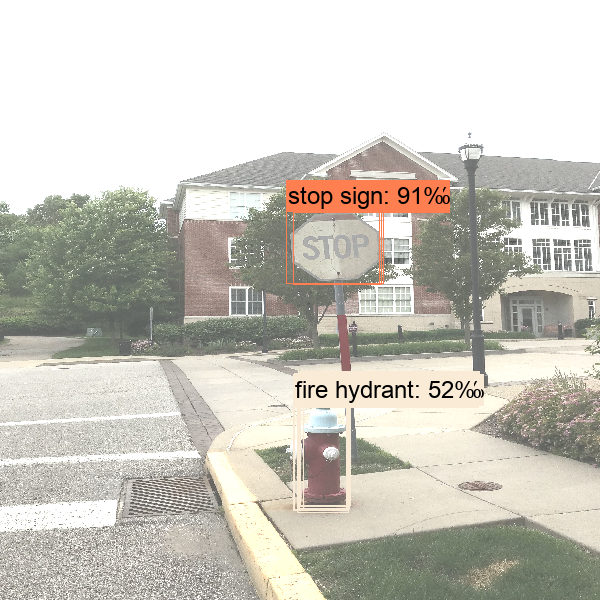

iter 100 total loss: 9.665464401245117


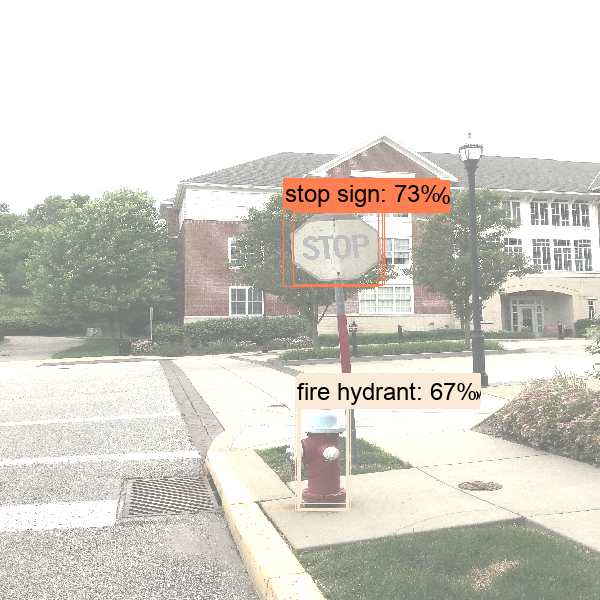

iter 120 total loss: 9.665464401245117


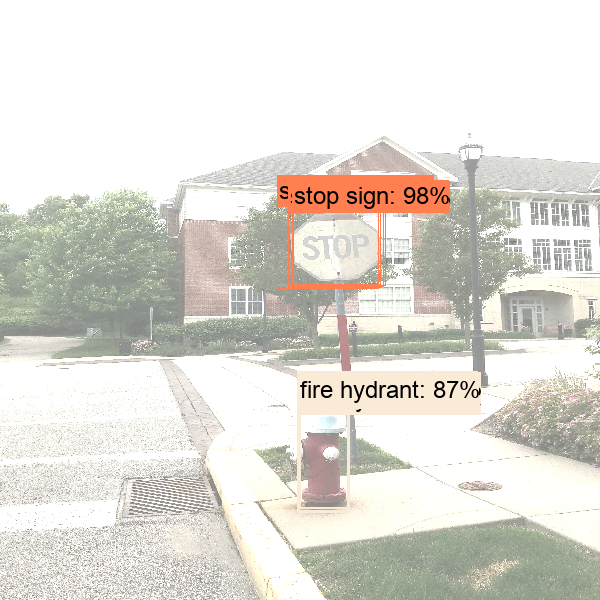

iter 140 total loss: 9.665464401245117


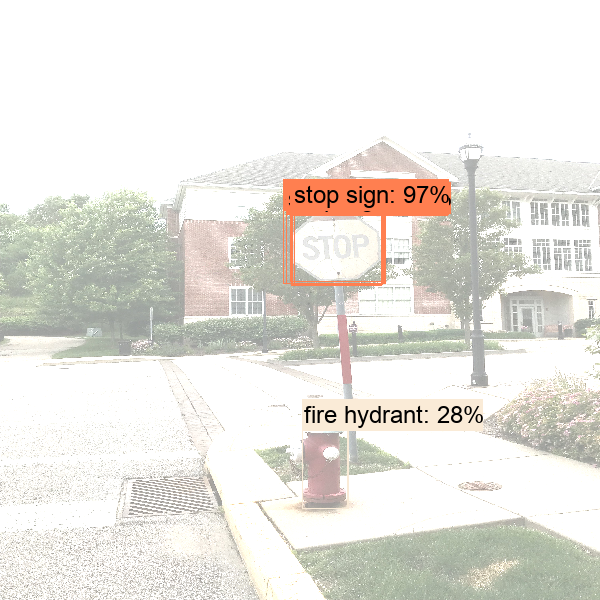

iter 160 total loss: 9.665464401245117


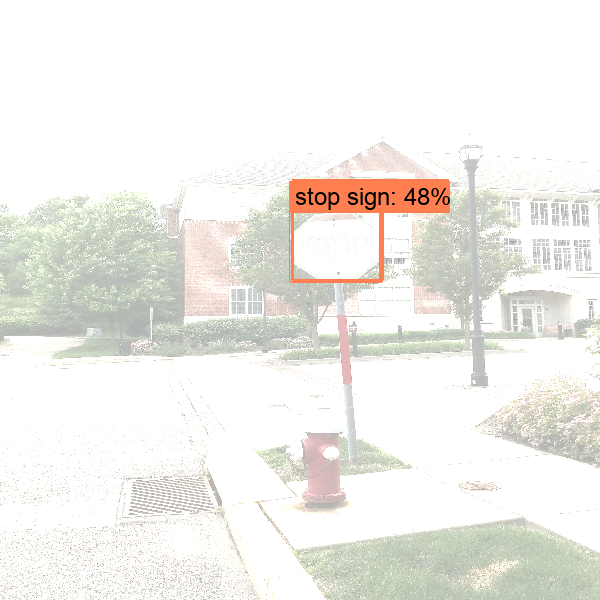

iter 180 total loss: 9.665464401245117


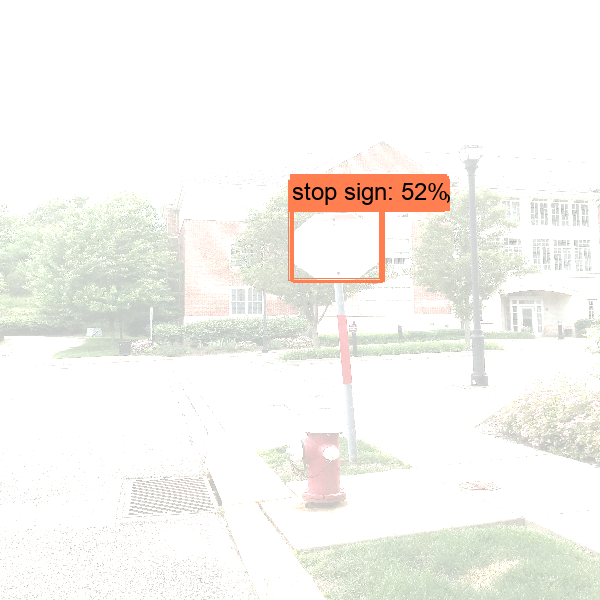

iter 200 total loss: 9.665464401245117


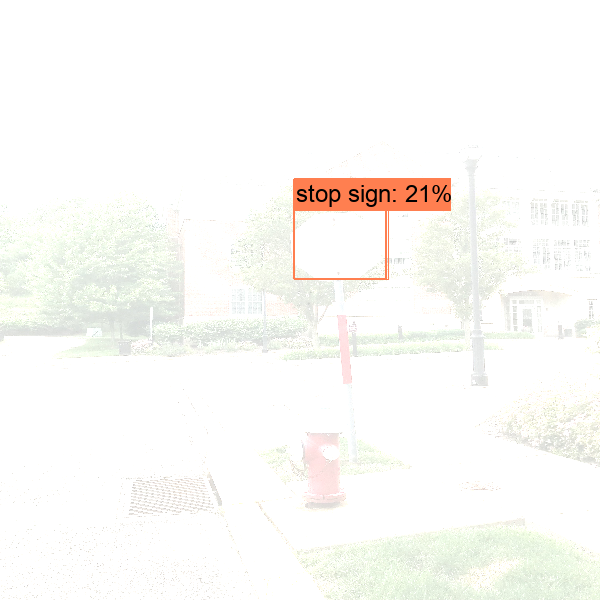

In [66]:
test_img = np.expand_dims(img, axis=0).copy()
for i in range(201):
    try:
        # Update patch according to changed labels
        loss, test_img, grad = model.train_step(test_img,target_labels,learning_rate=1e6)
        print(test_img)
#         test_img[:,212:280,291:380,:]+=0.005
#         test_img+=0.008
#         test_img=np.clip(test_img,-1,1)
        if (i % 20) == 0:
            print('iter {} total loss: {}'.format(i, loss))
            model.inference(test_img)

    except KeyboardInterrupt:
        print('iter {} total loss: {} target loss: {}'.format(i, loss, second_stage_cls_loss))
        break